# Taxi zone level regressions with covariates

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import math
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline

In [2]:
pooled_regression = pd.read_csv("Pooled_data/data_regression_PU.csv")

In [3]:

def run_zone_level_regression(data, PULocationID):
    """
    Run the regression for a given PULocationID, including time fixed effects,
    and return the results with heteroskedasticity-robust standard errors.
    
    Parameters:
    data (DataFrame): The panel data.
    PULocationID (int): The unique identifier for the location.
    
    Returns:
    dict: A dictionary with regression results for the given PULocationID.
    """
    # Subset the data for the current PULocationID
    temp_data = data[data['PULocationID'] == PULocationID]
    if temp_data.empty:
        print(f"The DataFrame is empty after filtering for {PULocationID}.")
    for col in ["tmax_obs", "log_total", "pr_obs"]:
        if temp_data[col].nunique() <= 1:
            print(f"{col} has no variation for {PULocationID}.")
    
    
    
    # if over half of "dynamic_tourism" is na then adapt formula:

    if temp_data["dynamic_tourism"].isna().sum() > temp_data.shape[0]/2:

        model_formula = 'log_total ~ 1 + tmax_obs + pr_obs + windspeed_obs + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)'
        tourism = False
        print(f"No dynamic tourism control for ZCTA {PULocationID}")


    else:
        # Define your model formula
        model_formula = 'log_total ~ 1 + tmax_obs + pr_obs + windspeed_obs + Weekday_index + dynamic_tourism + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)'
        tourism = True

    # Fit the model from formula
    model = sm.formula.ols(formula=model_formula, data=temp_data)
    results = model.fit(cov_type='HC3')  
    # Extract results and return them in a dictionary
    return {
        'PULocationID': PULocationID,
        'Coefficient_tmax_obs': results.params.get('tmax_obs', float('nan')),
        'CI_lower': results.conf_int().loc['tmax_obs'][0] if 'tmax_obs' in results.params else float('nan'),
        'CI_upper': results.conf_int().loc['tmax_obs'][1] if 'tmax_obs' in results.params else float('nan'),
        'p_value_tmax_obs': results.pvalues.get('tmax_obs', float('nan')),
        'num_observations': results.nobs,
        'tourism_control' : tourism
    }

# Load the data over 20 degrees
panel_data = pooled_regression[pooled_regression["tmax_obs"] >= 20]

# Get unique PULocationIDs and apply the regression function to each
unique_ids = panel_data['PULocationID'].unique()
results = [run_zone_level_regression(panel_data, id) for id in unique_ids]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a new CSV file
results_df.to_csv('regression_results_PU_20.csv', index=False)


No dynamic tourism control for ZCTA 2.0
No dynamic tourism control for ZCTA 30.0
No dynamic tourism control for ZCTA 46.0
No dynamic tourism control for ZCTA 57.0
No dynamic tourism control for ZCTA 58.0
No dynamic tourism control for ZCTA 59.0
No dynamic tourism control for ZCTA 105.0
No dynamic tourism control for ZCTA 156.0
No dynamic tourism control for ZCTA 172.0
No dynamic tourism control for ZCTA 184.0
No dynamic tourism control for ZCTA 187.0
No dynamic tourism control for ZCTA 201.0
No dynamic tourism control for ZCTA 206.0
No dynamic tourism control for ZCTA 264.0
No dynamic tourism control for ZCTA 265.0
No dynamic tourism control for ZCTA 118.0
No dynamic tourism control for ZCTA 204.0
No dynamic tourism control for ZCTA 245.0
No dynamic tourism control for ZCTA 251.0
No dynamic tourism control for ZCTA 104.0
No dynamic tourism control for ZCTA 109.0
No dynamic tourism control for ZCTA 115.0
No dynamic tourism control for ZCTA 221.0
No dynamic tourism control for ZCTA 44.0


In [4]:
sign = results_df[results_df["p_value_tmax_obs"] <= 0.1]

highest_neg_response = sign.sort_values(by = "Coefficient_tmax_obs", ascending = True).head(10)
highest_pos_response = sign.sort_values(by = "Coefficient_tmax_obs", ascending = False).head(10)

#### Plot all significant mobility responses : First : Pooled dataset with PULocation ID : How do pickups in the examined taxi zones change with higher temperature ?

In [7]:
# Read the taxizone shapefile
sf = shapefile.Reader("Shapefiles/geo_export_7766f064-29c1-4e13-b2d9-2e368707ff51.shp")

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

# look at shapefile and merge with longitude and latitude
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("location_i"), on="location_i")

In [6]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["location_i", "longitude", "latitude"])

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    col = continent
    
    # colorbar
    if len(heat) != 0:

         # Separate positive and negative values for different color maps
        pos_norm = mpl.colors.Normalize(vmin=0, vmax=max(heat.values()))
        neg_norm = mpl.colors.Normalize(vmin=min(heat.values()), vmax=0)

        # Define two color maps
        pos_cm = plt.get_cmap('Reds')
        neg_cm = plt.get_cmap('Blues_r')



        # Create and set the ScalarMappable objects for colorbars
        pos_sm = plt.cm.ScalarMappable(cmap=pos_cm, norm=pos_norm)
        neg_sm = plt.cm.ScalarMappable(cmap=neg_cm, norm=neg_norm)
        pos_sm.set_array([])
        neg_sm.set_array([])

        # Display the colorbars
        plt.colorbar(pos_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        plt.colorbar(neg_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R, G, B, A = (0, 0, 0, 1)  # Default color if no data
            else:
                heat_value = heat[loc_id]
                if heat_value > 0:
                    col = pos_cm(pos_norm(heat_value))
                elif heat_value < 0:
                    col = neg_cm(neg_norm(heat_value))
                else:
                    col = continent


        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['shape_area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [8]:
# merge df of results subset ( significant at least at 10% level)
plot_mobility_heat = sign.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)
plot_mobility_heat["Coefficient_tmax_obs"] = plot_mobility_heat["Coefficient_tmax_obs"] * 100

top3_sign= plot_mobility_heat.sort_values(by=['Coefficient_tmax_obs'], ascending=False).set_index("location_i").head(3)
bottom3_sign= plot_mobility_heat.sort_values(by=['Coefficient_tmax_obs'], ascending=True).set_index("location_i").head(3)

# concatenate the top and bottom 3
top_bottom = pd.concat([top3_sign, bottom3_sign])

mobility_response = dict(zip(plot_mobility_heat['location_i'].tolist(), plot_mobility_heat['Coefficient_tmax_obs'].tolist()))

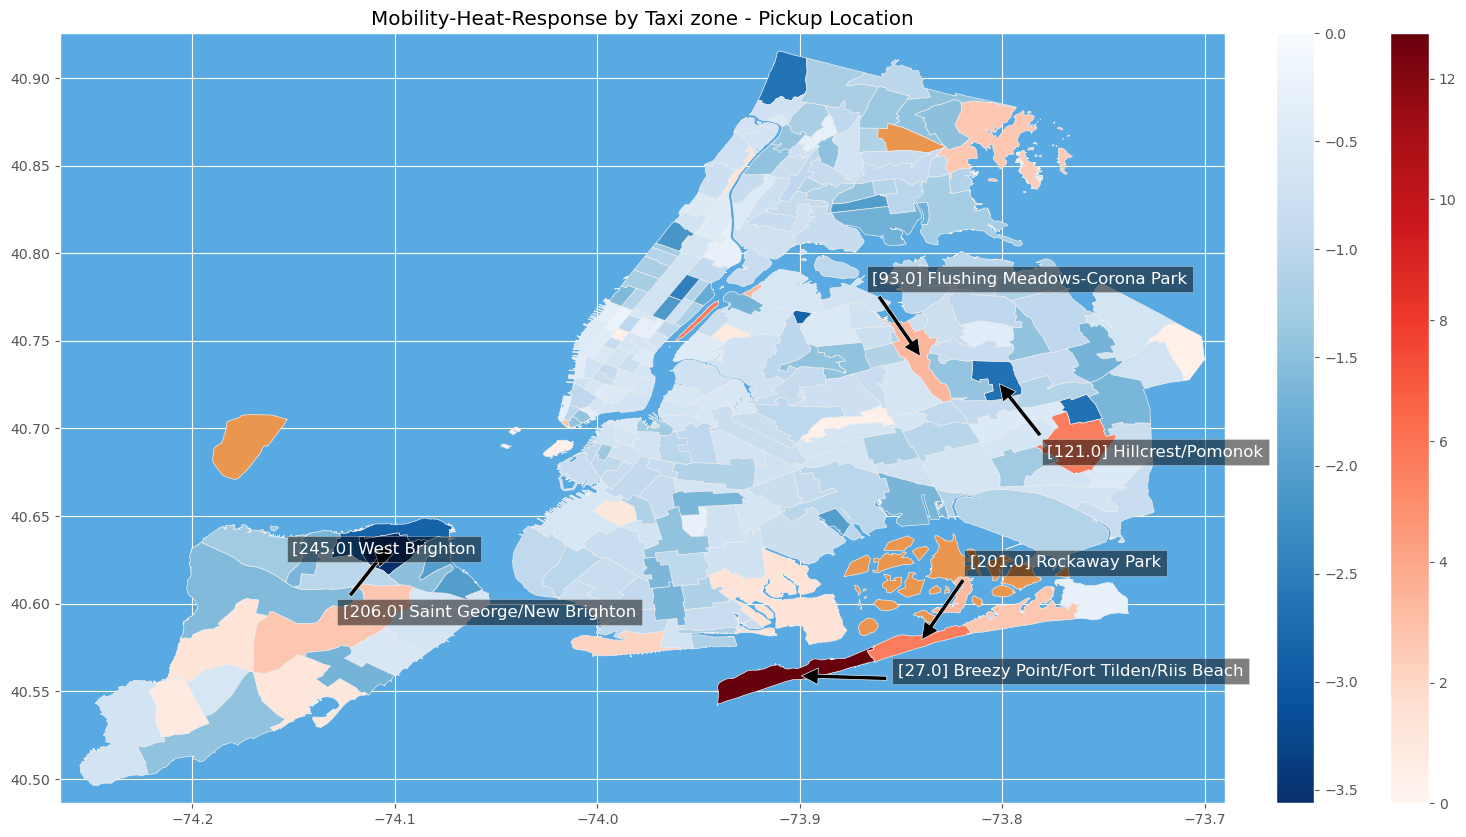

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
ax.set_title("Mobility-Heat-Response by Taxi zone - Pickup Location")

draw_zone_map(ax, sf, heat=mobility_response, text=top_bottom.index.tolist())

# Add a description at the bottom of the figure
description = "This map illustrates the mobility response estimated at the taxi-zone level with year fixed effects. Zones with a positive mobility response are shaded in red, while those with lower response are in blue. The intensity of the color indicates the magnitude of the response. \n Only zones with a statistically significant response at the 10% level or more are shown. In some of the individual regressions I did not control for dynamic tourism.The dataset used for this map is aggregated at the Pickup Location and includes Yellow, Green and FHV trips."
fig.text(0.5, 0.01, description, ha='center', va='center', fontsize=12)

plt.show()

1. Apparently: Beach and Park Areas show the highest increase in pickup mobility
2. Next step: Would be interesting to see where people who go to these areas go ?
    - Approach: preprocess data again for top 10 pickup locations and save corresponding dropoff locations in the dataset
    - Slice dataset and count where the most trips from those top10 locations went to : On days over 20 degrees (this subsample)
    - Might extend it with a probability estimation : Couple the heat-mobility coefficient and estimate which neighborhoods are most likely to be dropped off from that location

#### Spearman Correllations between mobility response and socioeconomic covariates : 

Split between positive and negative response taxi zones

In [97]:
import seaborn as sns

# 1. load socioeconomic data: 
socioeconomic = pd.read_csv("taxi_zones_with_socioeconomics.csv")

results_taxi_zone = plot_mobility_heat



def spearman_correlations( socioeconomic, results_taxi_zone, positive = True):

    """
    Calculates Spearman correlations and returns heatmap

    """



    merged = socioeconomic.merge(results_taxi_zone[["Coefficient_tmax_obs","location_i"]], left_on="LocationID", right_on="location_i")

    # calculate spearman correlation coefficient between the mobility response and the different socioeconomic variables

    socioeconomic_vars = ["medincome", "total_pop1", "fpl_100", "fpl_100to150", "median_rent",
                           "total_hholds1", 'hholds_snap', 'over16total_industry1', 'ag_industry',
                           'construct_industry', 'transpo_and_utilities_industry', 'total_commute1',
                           'drove_commute', 'pubtrans_bus_commute', 'pubtrans_subway_commute',
                           'pubtrans_ferry_commute', 'taxi_commute', 'bicycle_commute', 'walked_commute',
                           'workhome_commute', 'unemployed', 'under19_noinsurance', 'age19_34_noinsurance',
                           'age35_64_noinsurance', 'age65plus_noinsurance', 'hisplat_raceethnic',
                           'nonhispLat_white_raceethnic', 'nonhispLat_black_raceethnic',
                           'nonhispLat_amerindian_raceethnic', 'nonhispLat_asian_raceethnic', 'age65_plus',
                           'fpl_150', 'not_insured']
    selected_vars = ['Coefficient_tmax_obs'] + socioeconomic_vars
    # split dataset into negative and positive response

    if positive:
        data = merged[merged["Coefficient_tmax_obs"] < 0][selected_vars]
    else :
        data = merged[merged["Coefficient_tmax_obs"] >= 0][selected_vars]
        # convert coefficient tmax_obs to positive
        data["Coefficient_tmax_obs"] = data["Coefficient_tmax_obs"].abs()
    
    
    
    
    # Calculate Spearman correlation
    correlation = data.corr(method='spearman')
    correlation_row = correlation.loc[['Coefficient_tmax_obs']]
    max_corr = correlation_row.abs().max().max()

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    # set title
    if positive:
        plt.title("Spearman Correlation between Mobility Response and Socioeconomic Variables - Positive Response")
    else:
        plt.title("Spearman Correlation between Mobility Response and Socioeconomic Variables - Negative Response")
    
    # plot the heatmap : correlations below zero should be in blueshades , above zero in red shades


    sns.heatmap(correlation_row, annot=False, fmt=".2f", cmap='coolwarm', cbar=True, yticklabels=True ,  vmin=-max_corr, vmax=max_corr)

    # Show the plot
    plt.show()

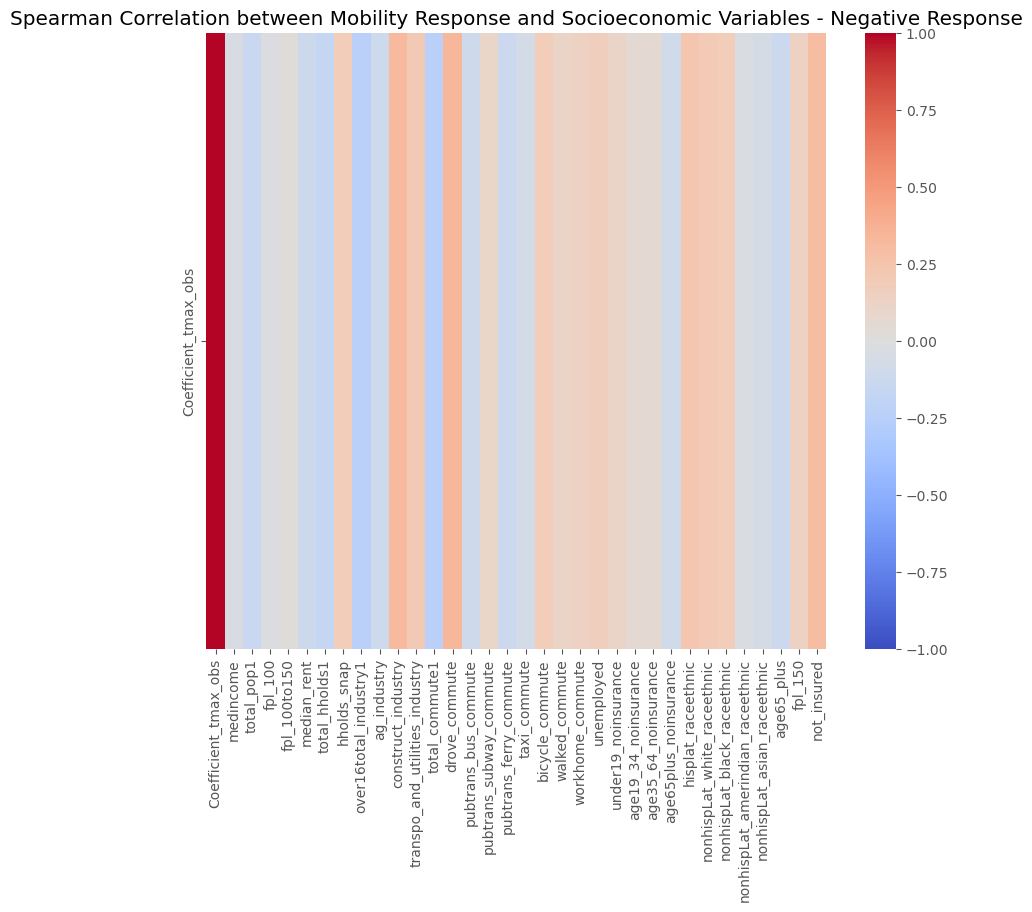

In [98]:
spearman_correlations(socioeconomic, results_taxi_zone,False)

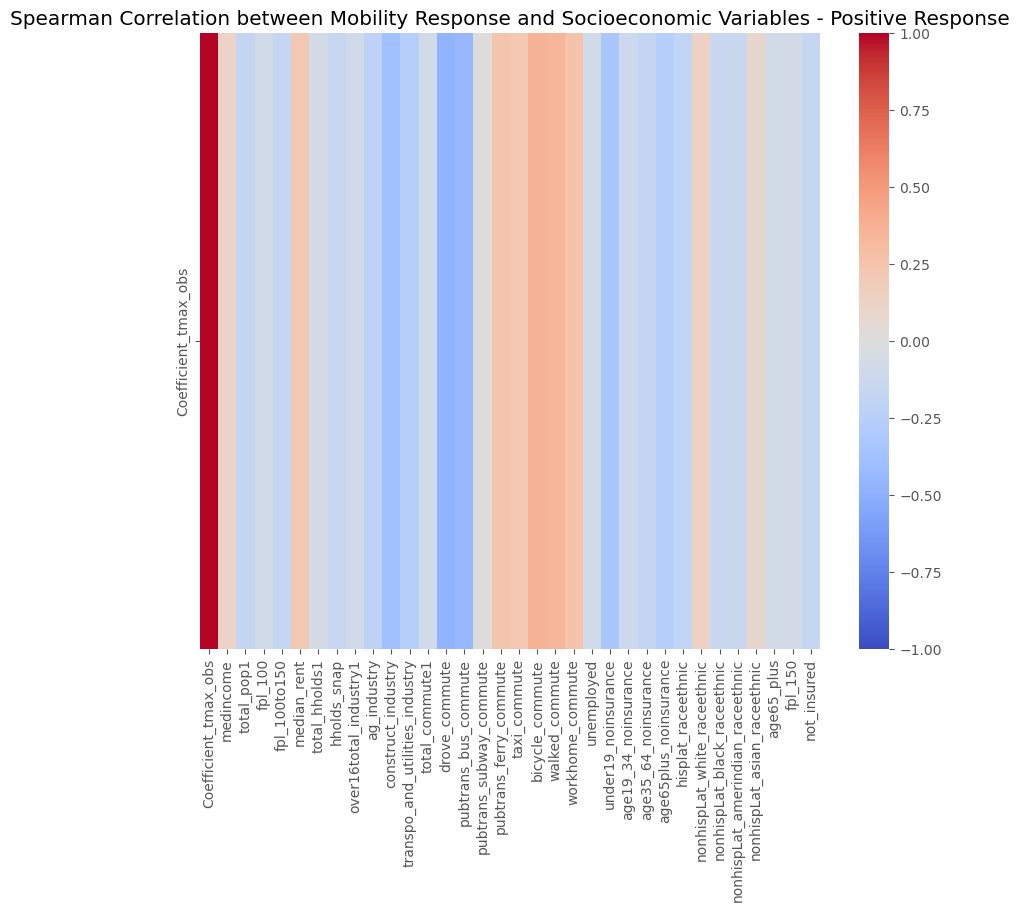

In [95]:
spearman_correlations(socioeconomic,results_taxi_zone,True)

Need to further include : Parks,Greenspace,Air Conditioning , Heat Vulnerability Index. 

#### Same for Dropoff Location: Green and Yellow Cabs

In [78]:
# First pool data

def pool_datasets_DO(yellow_cab_DO, green_cab_DO):
    """
    Pool multiple datasets into a single dataset.

    Parameters:
    - yellow_cab_DO: A pandas DataFrame containing Yellow Cab pickup data.
    - green_cab_DO: A pandas DataFrame containing Green Cab pickup data.

    Returns:
    - A pandas DataFrame with all input data pooled and aggregated at Pickup_Location Level.
    """
    # Concatenate the dataframes into one
    combined_df = pd.concat([yellow_cab_DO, green_cab_DO])

    # Group by 'date_pickup' and 'PULocationID' and aggregate the data
    pooled_trips = combined_df.groupby(['date_pickup', 'DOLocationID'], as_index=False).agg({
        'trip_distance_mean': 'mean',  
        'total_amount_mean': 'mean',   
        'trip_number': 'sum',
        # Assuming other columns are the same for each group, take 'first'
        **{col: 'first' for col in combined_df.columns if col not in ['date_pickup', 'DOLocationID', 
                                                                      'trip_distance_mean', 'total_amount_mean', 
                                                                      'trip_number']}
    })

    # Recalculate Chebyshev polynomials and year factors
    num_days = len(pooled_trips["date_pickup"].unique())
    pooled_trips['Year_fact'] = pd.factorize(pd.to_datetime(pooled_trips['date_pickup']).dt.year)[0] + 1
    pooled_trips['cheby_0'] = 1
    pooled_trips['cheby_1'] = pooled_trips['date_pickup'].rank(method='dense').astype(int) / num_days

    for i in range(2, 6):
        pooled_trips[f"cheby_{i}"] = (2 * pooled_trips["cheby_1"] * pooled_trips[f"cheby_{i-1}"]) - pooled_trips[f"cheby_{i-2}"]

    pooled_trips["log_total"] = np.log(pooled_trips["trip_number"] + 1)

    return pooled_trips

In [80]:
yellow = pd.read_csv("Yellow_Cab_data/data_regression_DO.csv")
green = pd.read_csv("Green_Cab_data/data_regression_DO.csv")

In [81]:
DO_pooled_YG = pool_datasets_DO(yellow,green)

In [82]:
import pandas as pd
import statsmodels.api as sm

def run_regression_DO(data, DOLocationID):
    """
    Run the regression for a given DOLocationID, including time fixed effects,
    and return the results with heteroskedasticity-robust standard errors.
    
    Parameters:
    data (DataFrame): The panel data.
    PULocationID (int): The unique identifier for the location.
    
    Returns:
    dict: A dictionary with regression results for the given PULocationID.
    """
    # Subset the data for the current PULocationID
    temp_data = data[data['DOLocationID'] == DOLocationID]
    if temp_data.empty:
        print(f"The DataFrame is empty after filtering for {DOLocationID}.")
    for col in ["tmax_obs", "log_total", "pr_obs"]:
        if temp_data[col].nunique() <= 1:
            print(f"{col} has no variation for {DOLocationID}.")
    
    
    
    # if over half of "dynamic_tourism" is na then adapt formula:

    if temp_data["dynamic_tourism"].isna().sum() > temp_data.shape[0]/2:

        model_formula = 'log_total ~ 1 + tmax_obs + pr_obs + windspeed_obs + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)'
        tourism = False
        print(f"No dynamic tourism control for ZCTA {DOLocationID}")


    else:
        # Define your model formula
        model_formula = 'log_total ~ 1 + tmax_obs + pr_obs + windspeed_obs + Weekday_index + dynamic_tourism + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)'
        tourism = True

    # Fit the model from formula
    model = sm.formula.ols(formula=model_formula, data=temp_data)
    results = model.fit(cov_type='HC3')  
    # Extract results and return them in a dictionary
    return {
        'DOLocationID': DOLocationID,
        'Coefficient_tmax_obs': results.params.get('tmax_obs', float('nan')),
        'CI_lower': results.conf_int().loc['tmax_obs'][0] if 'tmax_obs' in results.params else float('nan'),
        'CI_upper': results.conf_int().loc['tmax_obs'][1] if 'tmax_obs' in results.params else float('nan'),
        'p_value_tmax_obs': results.pvalues.get('tmax_obs', float('nan')),
        'num_observations': results.nobs,
        'tourism_control' : tourism
    }

# Load the data over 20 degrees
panel_data = DO_pooled_YG[DO_pooled_YG["tmax_obs"] >= 20]

# Get unique PULocationIDs and apply the regression function to each
unique_ids = DO_pooled_YG['DOLocationID'].unique()
results_DO = [run_regression_DO(panel_data, id) for id in unique_ids]

# Convert the results to a DataFrame
results_DO_df = pd.DataFrame(results_DO)

# Save the results to a new CSV file
results_DO_df.to_csv('regression_results_DO_taxi_zone.csv', index=False)

No dynamic tourism control for ZCTA 5
No dynamic tourism control for ZCTA 23
No dynamic tourism control for ZCTA 27
No dynamic tourism control for ZCTA 30
No dynamic tourism control for ZCTA 46
No dynamic tourism control for ZCTA 57
No dynamic tourism control for ZCTA 58
No dynamic tourism control for ZCTA 59
No dynamic tourism control for ZCTA 84
No dynamic tourism control for ZCTA 105
No dynamic tourism control for ZCTA 109
No dynamic tourism control for ZCTA 115
No dynamic tourism control for ZCTA 118
No dynamic tourism control for ZCTA 156
No dynamic tourism control for ZCTA 172
No dynamic tourism control for ZCTA 176
No dynamic tourism control for ZCTA 184
No dynamic tourism control for ZCTA 201
No dynamic tourism control for ZCTA 204
No dynamic tourism control for ZCTA 206
No dynamic tourism control for ZCTA 214
No dynamic tourism control for ZCTA 221
No dynamic tourism control for ZCTA 245
No dynamic tourism control for ZCTA 251
No dynamic tourism control for ZCTA 264
No dynamic

In [83]:
results_DO_df_sign = results_DO_df[results_DO_df["p_value_tmax_obs"] <= 0.1]

In [85]:
# merge df of results subset ( significant at least at 10% level)
DO_mobility_heat = results_DO_df_sign.merge(df_loc[["borough", "location_i", "zone"]], left_on="DOLocationID", right_on="location_i").drop("DOLocationID", axis=1)
DO_mobility_heat["Coefficient_tmax_obs"] = DO_mobility_heat["Coefficient_tmax_obs"] * 100

top3_sign_DO= DO_mobility_heat.sort_values(by=['Coefficient_tmax_obs'], ascending=False).set_index("location_i").head(3)
bottom3_sign_DO= DO_mobility_heat.sort_values(by=['Coefficient_tmax_obs'], ascending=True).set_index("location_i").head(3)

# concatenate the top and bottom 3
top_bottom = pd.concat([top3_sign_DO, bottom3_sign_DO])

mobility_response_DO = dict(zip(DO_mobility_heat['location_i'].tolist(), DO_mobility_heat['Coefficient_tmax_obs'].tolist()))

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


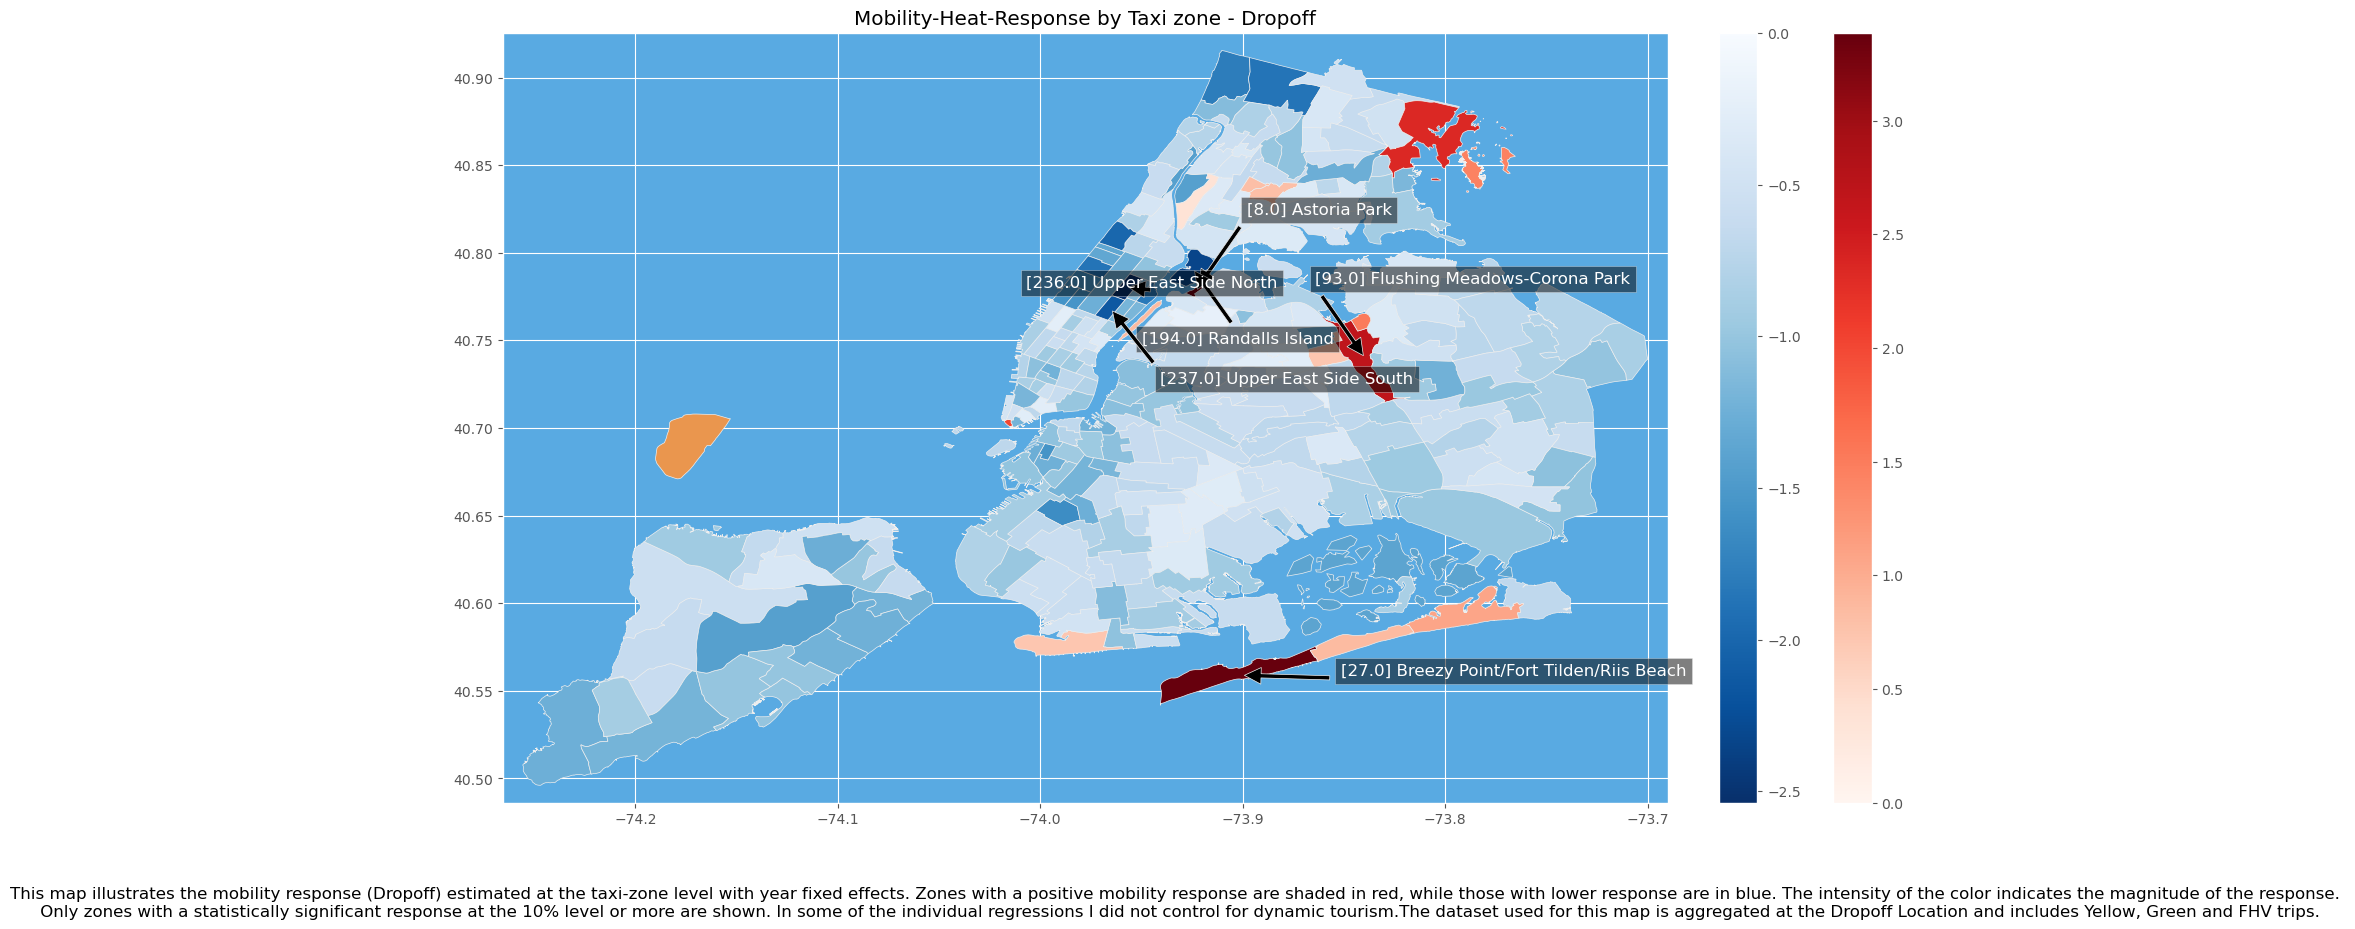

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
ax.set_title("Mobility-Heat-Response by Taxi zone - Dropoff")

draw_zone_map(ax, sf, heat=mobility_response_DO, text=top_bottom.index.tolist())

# Add a description at the bottom of the figure
description = "This map illustrates the mobility response (Dropoff) estimated at the taxi-zone level with year fixed effects. Zones with a positive mobility response are shaded in red, while those with lower response are in blue. The intensity of the color indicates the magnitude of the response. \n Only zones with a statistically significant response at the 10% level or more are shown. In some of the individual regressions I did not control for dynamic tourism.The dataset used for this map is aggregated at the Dropoff Location and includes Yellow, Green and FHV trips."
fig.text(0.5, 0.01, description, ha='center', va='center', fontsize=12)

plt.show()

In [73]:
socioeconomic = pd.read_csv("taxi_zones_with_socioeconomics.csv")

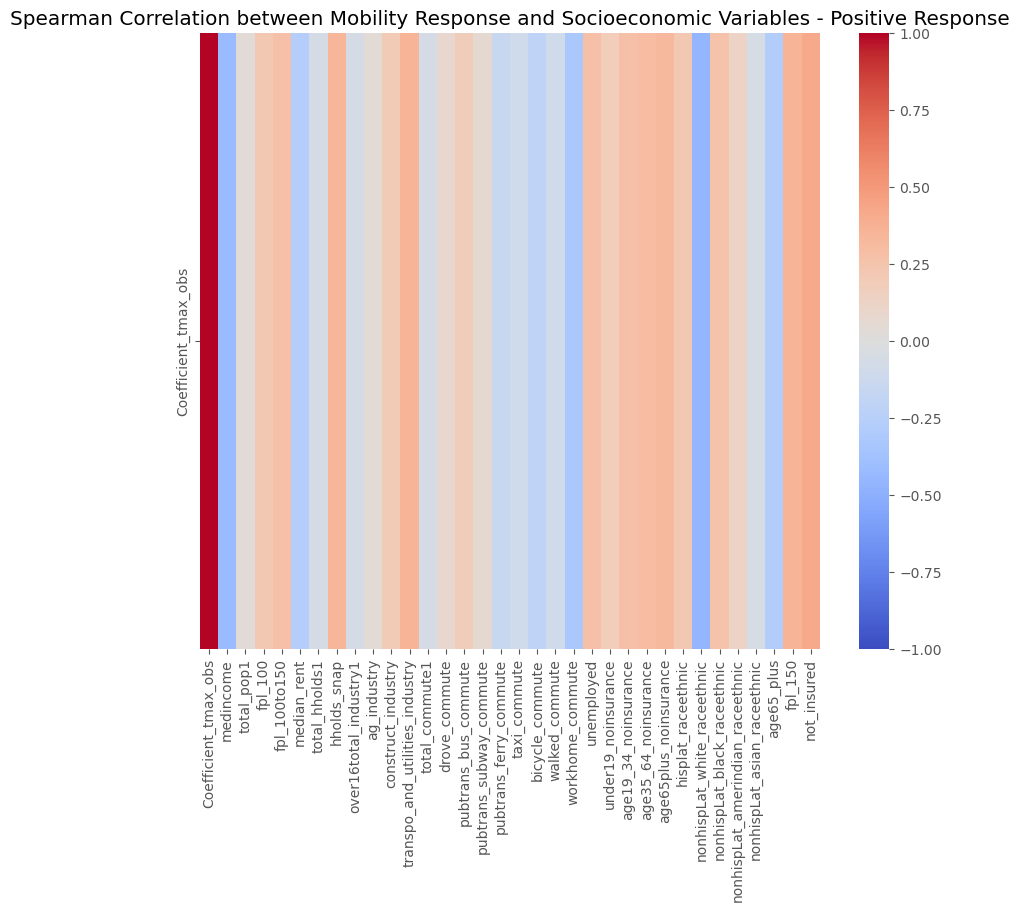

In [99]:
spearman_correlations(socioeconomic, DO_mobility_heat,True)

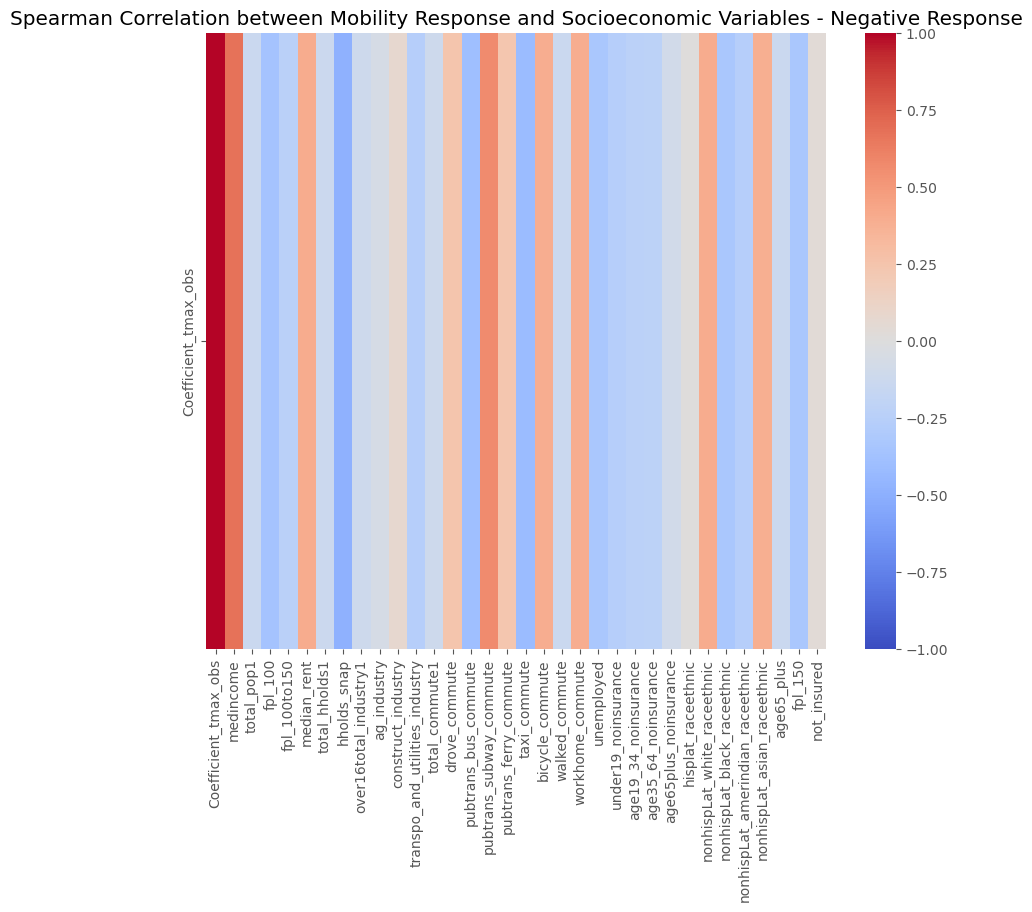

In [100]:
spearman_correlations(socioeconomic, DO_mobility_heat,positive=False)

In [2]:
globals().clear()
